In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.decomposition import PCA

%matplotlib inline

## Data Preparation

In [2]:
# import training data set
pp_train = pd.read_csv("../data/progresspics_2018_training_data.cvs")

In [3]:
pp_train.head()

sex   age  height  start_weight  end_weight  score  num_comments  \
0  1.0  34.0    68.0      189.0000   175.00000   1338            42   
1  1.0  35.0    76.0      316.0000   268.00000      1             1   
2  1.0  33.0    74.0      260.0000   220.00000      1             0   
3  1.0  27.0    74.0      235.0000   170.00000     44             2   
4  1.0  17.0    73.0      165.3465   211.64352      1             1   

   num_posts num_posts_cat  post_order  ...  gym  lifting  working  diet  \
0          3    (2.0, 4.0]         3.0  ...    0        0        0     0   
1          0   (-inf, 0.0]         0.0  ...    0        1        0     0   
2          8    (4.0, 8.0]         3.0  ...    0        0        0     0   
3          3    (2.0, 4.0]         3.0  ...    0        0        0     0   
4          1    (0.0, 1.0]         1.0  ...    0        0        0     0   

   muscle  nsfw  weight_diff  gain_or_lose  fill_period_weeks  change_rate  
0       0     0     14.00000             0         312.000000     0.044872  
1       0     0     48.00000             0          16.000000     3.000000  
2       0     0     40.00000             0          10.000000     4.000000  
3       0     0     65.00000             0          59.888934     1.085342  
4       0     0    -46.29702             1         156.000000    -0.296776  

[5 rows x 29 columns]

In [4]:
pp_train.shape

(17187, 29)

In [5]:
pp_train.columns

Index(['sex', 'age', 'height', 'start_weight', 'end_weight', 'score',
       'num_comments', 'num_posts', 'num_posts_cat', 'post_order', 'month',
       'dayofweek', 'progress', 'face', 'goal', 'finally', 'cico', 'keto',
       'gains', 'gym', 'lifting', 'working', 'diet', 'muscle', 'nsfw',
       'weight_diff', 'gain_or_lose', 'fill_period_weeks', 'change_rate'],
      dtype='object')

In [8]:
# create the feature set by dropping the target, "end_weight", "score" which is highly correlated 
# with "num_comments", "weigh_diff" which can be used with "start_weight" to exactly predict "end_weight",
# and "change_rate" which can be used with "fill_period_weeks" and "start_weight" to exactly predict "end_weight". 

# set the target, "end_weight", equal to y

pp_train_features = pp_train.drop(["end_weight", "score", "weight_diff", "change_rate"], axis=1)
y = pp_train.loc[:, 'end_weight']

In [9]:
# Are there any Nans?
pp_train_features.isnull().sum()

sex                  0
age                  0
height               0
start_weight         0
num_comments         0
num_posts            0
num_posts_cat        0
post_order           0
month                0
dayofweek            0
progress             0
face                 0
goal                 0
finally              0
cico                 0
keto                 0
gains                0
gym                  0
lifting              0
working              0
diet                 0
muscle               0
nsfw                 0
gain_or_lose         0
fill_period_weeks    0
dtype: int64

In [5]:
# Standard scale numerical columns and one-hot encode categorical columns that include categories other than 0 and 1. 
num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
cat_columns = ['month', 'dayofweek', 'num_posts', 'num_posts_cat', 'post_order']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X = data_prep_pipeline.fit_transform(pp_train_features.copy())

In [7]:
X.shape

(17187, 85)

In [8]:
X[0, :]

array([ 1.29083369,  0.015753  , -0.50173119,  3.84479427,  0.657463  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## Generate baseline/null models

In [10]:
# default null models from scikitlearn
null_model_median = DummyRegressor(strategy="median")
null_model_mean = DummyRegressor(strategy="mean")

In [11]:
# create a random baseline model where actual outcomes are shuffled at random and assigned as predictions
# inspired by: https://towardsdatascience.com/build-your-own-custom-scikit-learn-regression-5d0d718f289

class RandomRegressor(RegressorMixin, BaseEstimator):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)  # checks X and y for consistent length, makes sure X is 2D and y is 1D, no nans in y
        
        self.possible_targets_ = y
        return self
    
    def predict(self, X):
        check_is_fitted(self)  # checks estimator is fitted by looking for fitted attributes (those with trailing underscores)
        X = check_array(X)  # makes X is non empty 2D array containing finite values,  
        rng = np.random.default_rng(46)
        return rng.choice(self.possible_targets_, X.shape[0])   
    
null_model_random = RandomRegressor()

## Testing regression models with cross validation

In [21]:
# regression models to try
lin_reg = LinearRegression()
SGD_reg = SGDRegressor()
ridge_reg = Ridge()
lasso_reg = Lasso()
EN_reg = ElasticNet()
DT_reg = DecisionTreeRegressor()
RF_reg = RandomForestRegressor(n_estimators=100)
#HGB_reg = HistGradientBoostingRegressor()
GB_reg = GradientBoostingRegressor()
KN_reg = KNeighborsRegressor()
XGB_reg = XGBRegressor()

all_model_name_list = ["null_median", "null_mean", "null_random", "lin_reg", "SGD_reg", "ridge_reg", "lasso_reg", 
                       "EN_reg", "DT_reg", "RF_reg", "GB_reg", "KN_reg", "XGB_reg"]

all_model_list = [null_model_median, null_model_mean, null_model_random, lin_reg, SGD_reg, ridge_reg, lasso_reg, 
                  EN_reg, DT_reg, RF_reg, GB_reg, KN_reg, XGB_reg]

In [12]:
def model_testing(X, y, models, model_names):
    """Takes a pandas df of prepared features, a pandas series of corresponding targets and runs all models 
    specificed in the "models" list in a cross validation scheme with 10 folds. Returns a dataframe containing
    the mean RMSE and mean std for each model.
    
    Arguments:
    X -- pandas dataframe containing feature values
    y -- pandas series containing the target values
    models -- list of scikit models
    model_names -- list of strings of model names
    
    Returns:
    pandas dataframe containing the mean RMSE and mean standard deviation for each model in the "models" list
    """
    model_results = {}
    for count, model in enumerate(models):
        print("running", model_names[count])
        scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
        rmse_scores = np.sqrt(-scores)
        model_results[model_names[count]] = [rmse_scores.mean(), rmse_scores.std()]
    df = pd.DataFrame(model_results) 
    return df       

## Num_posts vs num_posts_cat

Both of these features represent the same information.  Which one is better to use?

In [14]:
# create a feature set that contains the "num_posts" feature, but not the "num_posts_cat" feature
pp_train_features_np = pp_train.drop(["end_weight", "score", "weight_diff", "change_rate", "num_posts_cat"], axis=1)

num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
cat_columns = ['month', 'dayofweek', 'num_posts', 'post_order']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X_np = data_prep_pipeline.fit_transform(pp_train_features_np.copy())

[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s


In [15]:
X_np.shape

(17187, 79)

In [59]:
# run the models using the feature set containing "num_posts"
np_df = model_testing(X_np, y, all_model_list, all_model_name_list)

running null_median
running null_mean
running null_random
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
running DT_reg
running RF_reg
running GB_reg
running KN_reg
running XGB_reg


In [60]:
# results
np_df

null_median  null_mean  null_random       lin_reg    SGD_reg  ridge_reg  \
0    45.708987  45.149057    64.013521  3.057082e+10  26.022426  25.422711   
1     1.510470   1.412266     0.986905  7.133860e+10   1.100586   1.054313   

   lasso_reg     EN_reg     DT_reg     RF_reg     GB_reg     KN_reg    XGB_reg  
0  26.654889  29.798488  29.273634  20.965851  22.257877  29.226759  21.641181  
1   1.158625   1.296732   1.031862   0.988780   1.011811   1.482259   1.060806

In [61]:
# create a feature set that contains the "num_post_cat" feature, but not the "num_posts" feature
pp_train_features_npc = pp_train_features = pp_train.drop(["end_weight", "score", "weight_diff", "change_rate", "num_posts"], axis=1)

num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
cat_columns = ['month', 'dayofweek', 'num_posts_cat', 'post_order']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X_npc = X = data_prep_pipeline.fit_transform(pp_train_features_npc.copy())

[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s


In [62]:
X_npc.shape

(17187, 65)

In [63]:
# run the models using the feature set containing "num_posts_cat"
npc_df = model_testing(X_npc, y, all_model_list, all_model_name_list)

running null_median
running null_mean
running null_random
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
running DT_reg
running RF_reg
running GB_reg
running KN_reg
running XGB_reg


In [64]:
# results
npc_df

null_median  null_mean  null_random       lin_reg    SGD_reg  ridge_reg  \
0    45.708987  45.149057    64.013521  7.085457e+10  26.117010  26.086030   
1     1.510470   1.412266     0.986905  1.183858e+11   1.067918   1.025466   

   lasso_reg     EN_reg     DT_reg     RF_reg     GB_reg     KN_reg    XGB_reg  
0  26.654889  29.798488  29.092947  20.980317  22.285625  29.309379  21.746995  
1   1.158625   1.296732   1.157907   1.018010   1.043680   1.457677   0.735196

### Results: 
Using the "num_posts' with one-hot coding worked slightly better than "num_post_cat" with one-hot encoding, so "num_posts_cat" will not be included in the feature dataset going forward.

The best linear regression model was ridge regression with an RMSE of 25.42.  The best overall regression model was Random Forest regression with an RMSE of 20.96 while Xtreme Gradiant Boost regression scored 21.61.  

In [16]:
# recreate the feature dataset using the "num_post" only
pp_train_features = pp_train.drop(["end_weight", "score", "weight_diff", "change_rate", "num_posts_cat"], axis=1)

num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
cat_columns = ['month', 'dayofweek', 'num_posts', 'post_order']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X = data_prep_pipeline.fit_transform(pp_train_features_np.copy())

[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s


In [17]:
X.shape

(17187, 79)

## Polynomial Features

In [18]:
# create five polynomial feature sets (power= 2, 3, 4, 5, 6) and store them in a dictionary, "poly_features"

poly_list = ["poly_X_2", "poly_X_3", "poly_X_4", "poly_X_5", "poly_X_6"]
poly_features = {}
for count, value in enumerate(poly_list, start=2):
    num_transformer = Pipeline([
        ('poly_features', PolynomialFeatures(degree=count)), 
        ('std_scaler', StandardScaler())],
        verbose=True) 
    col_preprocessing = ColumnTransformer([
        ('numeric_col_preprocessing', num_transformer, num_columns),
        ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
        remainder='passthrough', verbose=True)
    data_prep_pipeline = Pipeline([
        ('col_preprocessing', col_preprocessing)],
        verbose=True)
    poly_features[value] = data_prep_pipeline.fit_transform(pp_train_features.copy())

[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing std_scaler, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing std_scaler, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ........ (step 2 of 2) Process

In [22]:
# linear regression models to use with the poly features
linreg_model_name_list = ["null_median", "null_mean", "lin_reg", "SGD_reg", "ridge_reg", "lasso_reg", "EN_reg"]
linreg_model_list = [null_model_median, null_model_mean, lin_reg, SGD_reg, ridge_reg, lasso_reg, EN_reg]

In [23]:
# run each linear regression model with each set of poly features
for key, value in poly_features.items(): 
    df = model_testing(value, y, linreg_model_list, linreg_model_name_list)
    print()
    print(key)
    print(df)
    print()

running null_median
running null_mean
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
poly_X_2
   null_median  null_mean       lin_reg    SGD_reg  ridge_reg  lasso_reg  \
0    45.708987  45.149057  2.907789e+10  25.249937  24.439054  25.809206   
1     1.510470   1.412266  6.634872e+10   1.283887   1.073089   1.260130   

      EN_reg  
0  27.736453  
1   1.262059  

running null_median
running null_mean
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
poly_X_3
   null_median  null_mean    lin_reg       SGD_reg  ridge_reg  lasso_reg  \
0    45.708987  45.149057  23.780143  3.056709e+10  23.741079  25.804518   
1     1.510470   1.412266   1.369579  4.486897e+10   1.328466   1.234689   

      EN_reg  
0  27.218690  
1   1.325483  

running null_median
running null_mean
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
poly_X_4
   null_median  null_mean    lin_reg       SGD_reg  ridge_re

/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4250.681234691292, tolerance: 3145.1392415755395
  positive)
/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4840.615353891626, tolerance: 3155.483331438043
  positive)


running EN_reg
poly_X_5
   null_median  null_mean    lin_reg       SGD_reg  ridge_reg  lasso_reg  \
0    45.708987  45.149057  35.746510  2.285706e+11  23.475886  25.648578   
1     1.510470   1.412266  24.081964  1.289261e+11   1.236193   1.246198   

      EN_reg  
0  27.104337  
1   1.289707  

running null_median
running null_mean
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg


/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3547.3568549808115, tolerance: 3145.1392415755395
  positive)
/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3608.450726956129, tolerance: 3186.86550514384
  positive)
/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5720.624106094241, tolerance: 3155.483331438043
  positive)


running EN_reg
poly_X_6
   null_median  null_mean     lin_reg       SGD_reg  ridge_reg  lasso_reg  \
0    45.708987  45.149057  180.552708  7.233847e+11  24.577120  25.611824   
1     1.510470   1.412266  179.166464  2.757869e+11   3.301092   1.220689   

      EN_reg  
0  27.095580  
1   1.281154  



### Results:
With the original feature set, ridge regression was the best linear model (RMSE=25.42).  Increasing the power of the polynomial feature sets improved ridge regression to a best RMSE of 23.33 with power=4, then the RMSE increased with the power at 5 and 6.  Linear regression also improved with increasing power up to 4 (RMSE=23.64), then got worse. The Lasso RMSE stayed about the same for each polynomial dataset and SGD got worse as the power increased.  None of the polynomial data sets / linear regression models did better than the Random Forest RMSE (20.96).

## PCA

In [71]:
# use PCA to reduce the dimensionality of the original dataset
pca = PCA()
X_pca = pca.fit_transform(X)

In [72]:
# which PCA components contain most of the variance of the original dataset?
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.77849247e-01, 1.27927865e-01, 1.07647304e-01, 1.00018479e-01,
       7.52151718e-02, 6.02857833e-02, 2.91392332e-02, 1.62311664e-02,
       1.60386848e-02, 1.59630678e-02, 1.58138226e-02, 1.54332188e-02,
       1.49284542e-02, 1.46159846e-02, 1.23793215e-02, 1.14142001e-02,
       1.07786688e-02, 1.05210385e-02, 1.04603752e-02, 9.84699544e-03,
       9.77275367e-03, 9.62515730e-03, 9.18508359e-03, 9.00499760e-03,
       8.97230279e-03, 8.77994699e-03, 8.41954365e-03, 7.67474184e-03,
       7.05130244e-03, 6.86310494e-03, 6.60392191e-03, 5.86291150e-03,
       5.01803424e-03, 4.89522392e-03, 4.39474417e-03, 3.88206212e-03,
       3.71152714e-03, 3.32088639e-03, 3.10391590e-03, 3.00958765e-03,
       2.79203320e-03, 2.61837320e-03, 2.15050659e-03, 1.94294230e-03,
       1.67950745e-03, 1.39203115e-03, 1.00265291e-03, 8.03773755e-04,
       6.78450786e-04, 5.48002368e-04, 4.70052510e-04, 3.84626541e-04,
       3.11952010e-04, 2.91707066e-04, 2.12075828e-04, 1.61881876e-04,
      

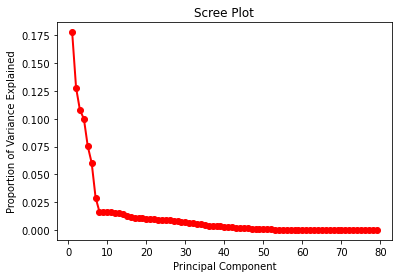

In [73]:
# plot scree plot to help determine how many components to include when modeling
# code from https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

### How many components to include?

80% of the variance is included in components 1-13, while 90% of the varience is in components 1-24. Using the scree plot, there is an eblow after components 1-7.  So let's try all three options. 

In [74]:
# create dictionary holding the 3 different PCA feature sets
num_components = [7, 13, 24]
pca_features = {}
for num in num_components:
    pca = PCA(n_components=num)
    pca_features[str(num)] = pca.fit_transform(X)

In [75]:
# run each regression model using each PCA feature set
for key, value in pca_features.items(): 
    df = model_testing(value, y, all_model_list, all_model_name_list)
    print()
    print("number of PCA components", key)
    print(df)
    print()

running null_median
running null_mean
running null_random
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
running DT_reg
running RF_reg
running GB_reg
running KN_reg
running XGB_reg

number of PCA components 7
   null_median  null_mean  null_random    lin_reg    SGD_reg  ridge_reg  \
0    45.708987  45.149057    64.013521  28.348965  28.450454  28.348960   
1     1.510470   1.412266     0.986905   1.278071   1.306747   1.278072   

   lasso_reg     EN_reg     DT_reg     RF_reg     GB_reg     KN_reg    XGB_reg  
0  28.484411  30.262162  35.154143  24.835273  25.104132  27.036125  25.506875  
1   1.278877   1.305624   2.032995   1.742131   1.650772   1.850790   1.729374  

running null_median
running null_mean
running null_random
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
running DT_reg
running RF_reg
running GB_reg
running KN_reg
running XGB_reg

number of PCA components 13
   null_median  null_mean  null_random 

### Results:
The three PCA feature sets gave similar results to each other (all within 1-2 points) and most of which are worse than the best models using the original dataset.  Given the relatively small size of the dataset and the observed loss of performance, PCA is not a good fit for this modeling situtation. 

## Feature Importance

In [76]:
# Below is a third party function that gets feature names.  Code and explanation on this website: 
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

import warnings
import sklearn
import pandas as pd

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

### What are the most important features for the linear regression model?

In [77]:
# Regenerate the original X feature set 
num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
cat_columns = ['month', 'dayofweek', 'num_posts', 'post_order']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X = data_prep_pipeline.fit_transform(pp_train_features.copy())

[ColumnTransformer]  (1 of 3) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing cat_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s


In [78]:
ridge_reg.fit(X, y)
ridge_reg_feat_import = pd.DataFrame(ridge_reg.coef_, index = get_feature_names(col_preprocessing))
ridge_reg_feat_import.columns = ["Feature Importance"]
ridge_reg_feat_import.sort_values("Feature Importance", ascending=False).head(20)

/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Transformer numeric_col_preprocessing (type StandardScaler) does not provide get_feature_names. Will return input column names if available


Feature Importance
cat_col_preprocessing__x2_19                     199.349866
cat_col_preprocessing__x2_12                      42.019266
gain_or_lose                                      37.378758
numeric_col_preprocessing__start_weight           35.415688
cat_col_preprocessing__x3_1.0                     16.198875
cat_col_preprocessing__x3_2.0                     10.901943
numeric_col_preprocessing__height                  7.370312
nsfw                                               6.944394
cat_col_preprocessing__x3_3.0                      6.867424
keto                                               4.948227
gains                                              3.593554
progress                                           3.074064
cat_col_preprocessing__x3_13.0                     2.853777
cat_col_preprocessing__x3_18.0                     2.510582
cat_col_preprocessing__x3_4.0                      2.430756
face                                               2.286671
cat_col_preprocessing__x3_19.0                     1.996893
goal                                               1.949189
cico                                               1.717553
cat_col_preprocessing__x3_11.0                     1.586981

In [83]:
ridge_reg_feat_import.sort_values("Feature Importance", ascending=False).tail(30)

Feature Importance
cat_col_preprocessing__x3_6.0                          -2.579536
muscle                                                 -2.666102
cat_col_preprocessing__x2_13                           -3.089250
cat_col_preprocessing__x0_1                            -3.195590
cat_col_preprocessing__x3_10.0                         -3.335078
numeric_col_preprocessing__fill_period_weeks           -3.995176
cat_col_preprocessing__x3_7.0                          -4.119399
cat_col_preprocessing__x3_0.0                          -4.307605
cat_col_preprocessing__x2_0                            -4.307605
numeric_col_preprocessing__num_comments                -4.352789
cat_col_preprocessing__x3_12.0                         -5.374064
cat_col_preprocessing__x3_16.0                         -6.038241
cat_col_preprocessing__x2_17                           -6.075286
cat_col_preprocessing__x2_11                           -6.649805
cat_col_preprocessing__x3_14.0                         -7.181397
cat_col_preprocessing__x2_14                           -7.594508
cat_col_preprocessing__x2_7                            -8.353348
cat_col_preprocessing__x3_17.0                        -10.782212
cat_col_preprocessing__x2_16                          -12.045557
cat_col_preprocessing__x2_6                           -12.079641
cat_col_preprocessing__x2_9                           -12.433270
cat_col_preprocessing__x2_5                           -13.947517
cat_col_preprocessing__x2_15                          -15.385163
cat_col_preprocessing__x2_8                           -15.607509
cat_col_preprocessing__x2_10                          -15.963311
cat_col_preprocessing__x2_3                           -17.584298
cat_col_preprocessing__x2_4                           -18.555951
cat_col_preprocessing__x2_2                           -19.915383
cat_col_preprocessing__x2_1                           -22.948695
cat_col_preprocessing__x2_18                          -28.833035

In [85]:
# what are the most important features for the random forest model?
RF_reg.fit(X,y)

RF_feat_import = pd.DataFrame(RF_reg.feature_importances_, index = get_feature_names(col_preprocessing))
RF_feat_import.columns = ["Feature Importance"]

RF_feat_import.sort_values("Feature Importance", ascending=False).head(30)

/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Transformer numeric_col_preprocessing (type StandardScaler) does not provide get_feature_names. Will return input column names if available


Feature Importance
numeric_col_preprocessing__start_weight                 0.639355
numeric_col_preprocessing__fill_period_weeks            0.082646
numeric_col_preprocessing__height                       0.063560
gain_or_lose                                            0.040590
numeric_col_preprocessing__num_comments                 0.034813
numeric_col_preprocessing__age                          0.027037
sex                                                     0.008321
cat_col_preprocessing__x1_0                             0.004828
cat_col_preprocessing__x1_5                             0.004513
cat_col_preprocessing__x2_1                             0.004278
cat_col_preprocessing__x0_9                             0.004075
cat_col_preprocessing__x0_11                            0.003522
progress                                                0.003318
cat_col_preprocessing__x1_6                             0.003253
cat_col_preprocessing__x1_3                             0.003241
cat_col_preprocessing__x1_1                             0.003174
cat_col_preprocessing__x0_4                             0.003109
cat_col_preprocessing__x3_1.0                           0.003056
cat_col_preprocessing__x0_3                             0.003035
cat_col_preprocessing__x2_19                            0.002951
cat_col_preprocessing__x0_10                            0.002944
cat_col_preprocessing__x1_2                             0.002813
face                                                    0.002682
cico                                                    0.002668
cat_col_preprocessing__x2_2                             0.002576
cat_col_preprocessing__x1_4                             0.002550
cat_col_preprocessing__x0_12                            0.002436
cat_col_preprocessing__x0_8                             0.002418
cat_col_preprocessing__x0_5                             0.002413
cat_col_preprocessing__x0_6                             0.002217

In [84]:
# what are the most important features for the XGBoost model?
XGB_reg.fit(X,y)

XGB_feat_import = pd.DataFrame(XGB_reg.feature_importances_, index=get_feature_names(col_preprocessing))
XGB_feat_import.columns = ["Feature Importance"]

XGB_feat_import.sort_values("Feature Importance", ascending=False).head(30)

/Users/ajwright/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Transformer numeric_col_preprocessing (type StandardScaler) does not provide get_feature_names. Will return input column names if available


Feature Importance
gain_or_lose                                            0.182636
numeric_col_preprocessing__start_weight                 0.178305
cat_col_preprocessing__x2_19                            0.065285
numeric_col_preprocessing__fill_period_weeks            0.035405
numeric_col_preprocessing__height                       0.031991
sex                                                     0.031961
cat_col_preprocessing__x2_8                             0.027706
cat_col_preprocessing__x3_3.0                           0.021719
cat_col_preprocessing__x3_1.0                           0.020938
cat_col_preprocessing__x1_5                             0.016897
cat_col_preprocessing__x2_1                             0.016488
cat_col_preprocessing__x0_9                             0.015960
face                                                    0.015345
cat_col_preprocessing__x1_0                             0.015339
nsfw                                                    0.015090
cat_col_preprocessing__x2_0                             0.014946
cat_col_preprocessing__x0_11                            0.012917
progress                                                0.012794
numeric_col_preprocessing__num_comments                 0.012306
keto                                                    0.011508
cico                                                    0.010818
diet                                                    0.008784
gains                                                   0.008639
cat_col_preprocessing__x2_3                             0.008638
cat_col_preprocessing__x2_10                            0.008435
cat_col_preprocessing__x2_5                             0.008405
cat_col_preprocessing__x0_4                             0.008032
cat_col_preprocessing__x0_8                             0.007873
cat_col_preprocessing__x1_1                             0.007639
cat_col_preprocessing__x0_5                             0.007378

### Results

It is interesting how different models rely on different subsets of the feature set. 

In the Ridge regression model, the most important feature is the one-hot-encoded category of num_posts_19.  Other num_posts categories also have significant coefficents as does "gain_lose", "start_weight", and "height", several key words, as well as a few categories of "post_order".  None of the coeffiencents drop to 0 suggesting that all the features are important in this ridge regression model.  

In the Random Forest model, the most important feature by far is "start_weight" with "fill_period_weeks", "height", "gain_or_lose", "num_comments", and "age" making minor contributions. 

In the XGBoost model, the "gain_or_lose" and "start_weight" have equal importance with the next feature being num_post_19 again.  The remainder of the features make a lower, but non-negligable contribution.  

## Modeling with a smaller feature set

Try modelling with just the features most important to the random forest model.  Compare performance of this smaller feature set to the entire set for random forest and all the other regression models.

In [42]:
# import only the subset features 
pp_train_small = pd.read_csv("progresspics_2018_training_data.cvs", usecols=['start_weight', 'fill_period_weeks', 
                                                                            "height", "gain_or_lose", "num_comments",
                                                                            "age"])

In [44]:
pp_train_small.head()

age  height  start_weight  num_comments  gain_or_lose  fill_period_weeks
0  34.0    68.0      189.0000            42             0         312.000000
1  35.0    76.0      316.0000             1             0          16.000000
2  33.0    74.0      260.0000             0             0          10.000000
3  27.0    74.0      235.0000             2             0          59.888934
4  17.0    73.0      165.3465             1             1         156.000000

In [43]:
# small subset feature set preparation
num_columns = ['age', 'height', 'start_weight', 'fill_period_weeks', 'num_comments']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns)], 
    remainder='passthrough', verbose=True)

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

X_small = data_prep_pipeline.fit_transform(pp_train_small.copy())

[ColumnTransformer]  (1 of 2) Processing numeric_col_preprocessing, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.0s


In [90]:
# modeling
small_df = model_testing(X_small, y, all_model_list, all_model_name_list)

running null_median
running null_mean
running null_random
running lin_reg
running SGD_reg
running ridge_reg
running lasso_reg
running EN_reg
running DT_reg
running RF_reg
running GB_reg
running KN_reg
running XGB_reg


In [108]:
# to make it easier to compare, put the full and subset modeling results in the same dataframe
compare_df = pd.concat([np_df.iloc[0, :], small_df.iloc[0, :]], axis=1)
compare_df.columns = ["full_features", "subset_features"]
compare_df["best_feature_set"] = compare_df.apply(lambda row: "subset" if row[0] > row[1] else "full", axis=1)
compare_df["difference"] = compare_df["subset_features"] - compare_df["full_features"]

In [110]:
compare_df.sort_values('full_features')

full_features  subset_features best_feature_set    difference
RF_reg        2.096585e+01        21.373161             full  4.073101e-01
XGB_reg       2.164118e+01        21.812550             full  1.713693e-01
GB_reg        2.225788e+01        22.268619             full  1.074214e-02
ridge_reg     2.542271e+01        26.240611             full  8.178997e-01
SGD_reg       2.602243e+01        26.190916             full  1.684895e-01
lasso_reg     2.665489e+01        26.654889           subset -5.073891e-07
KN_reg        2.922676e+01        24.768709           subset -4.458050e+00
DT_reg        2.927363e+01        28.883267           subset -3.903675e-01
EN_reg        2.979849e+01        29.830806             full  3.231762e-02
null_mean     4.514906e+01        45.149057             full  0.000000e+00
null_median   4.570899e+01        45.708987             full  0.000000e+00
null_random   6.401352e+01        64.013521             full  0.000000e+00
lin_reg       3.057082e+10        26.240624           subset -3.057082e+10

### Results

The modeling using the full feature set gives better results (just barely) for the top 3 models: Ridge (by 0.82), Random_Forest (by 0.41), and XGB_reg (by 0.17).  

## Hyperparameter optimization

### Starting RMSE for Ridge Regression with original dataset is 25.42.  
The main hyperparameter to optimize for ridge regression is alpha. 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=46)
grid = dict()
grid["alpha"] = np.arange(0, 1, 0.01)
search = GridSearchCV(ridge_reg, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(X, y)

In [112]:
print("RSME", np.sqrt(-results.best_score_))
print("Best parameters", results.best_params_)

RSME 25.430262514231817
Best parameters {'alpha': 0.13}


In [20]:
opt_ridge_reg = Ridge(alpha=0.13)
opt_ridge_reg_df = model_testing(X, y, [opt_ridge_reg], ["opt_ridge_reg"])

running opt_ridge_reg


In [21]:
opt_ridge_reg_df

opt_ridge_reg
0      25.415511
1       1.064661

### Results:
Tuning the alpha hyperparameter did not improve the RMSE of the ridge regression model.  It stayed at 25.42. 

### Starting RMSE for Ridge Regression with the polynomial (power=4) data set is 23.33

In [28]:
results_poly = search.fit(poly_features['poly_X_4'], y)

In [29]:
print("RSME", np.sqrt(-results_poly.best_score_))
print("Best parameters", results_poly.best_params_)

RSME 23.391823429156595
Best parameters {'alpha': 0.31}


In [33]:
opt_ridge_reg_poly = Ridge(alpha=.31)
opt_ridge_reg_poly_df = model_testing(poly_features['poly_X_4'], y, [opt_ridge_reg_poly], ["opt_ridge_reg_poly"])

running opt_ridge_reg_poly


In [34]:
opt_ridge_reg_poly_df

opt_ridge_reg_poly
0           23.292366
1            1.237685

### Results
Tuning the alpha hyperparameter of the ridge regression model using the polynomial (power=4) feature set improved the RMSE from 23.33 to 23.39, a difference of 0.04. 

### Starting RMSE for Random Forest is 20.96

In [115]:
# use random grid search to explore a hyperparameter space for the random forest model
# parameter suggestions from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# took > 1.5 hrs to run

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=RF_reg, param_distributions=random_grid, scoring='neg_mean_squared_error',
                               n_iter=100, cv=3, verbose=2, random_state=46, n_jobs = -1)

rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=46, scoring='neg_mean_squared_error',
                   verbose=2)

In [132]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [131]:
rf_random.best_score_

-452.8611772470158

In [15]:
# try the optimized paramenters in a random forest model
opt_RF_reg = RandomForestRegressor(n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features='auto',
 max_depth=60, bootstrap=True)
opt_RF_reg_results_df = model_testing(X, y, [opt_RF_reg], ["opt_RF_reg"])

running opt_RF_reg


In [16]:
 opt_RF_reg_results_df

opt_RF_reg
0   20.831322
1    0.959013

In [29]:
# Try a new random grid search using different parameter values
# https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [500, 800, 1500, 2500, 5000]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]

random_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf_random2 = RandomizedSearchCV(estimator = RF_reg, param_distributions = random_grid2, n_iter = 100, scoring='neg_mean_squared_error', 
                                cv = 3, verbose=2, random_state=46, n_jobs = -1)

rf_random2.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [500, 800, 1500, 2500,
                                                         5000]},
                   random_state=46, scoring='neg_mean_squared_error',
                   verbose=2)

In [30]:
rf_random2.best_params_

{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40}

In [31]:
rf_random2.best_score_

-453.02797610149906

In [32]:
# try the optimized paramenters in a random forest model
opt2_RF_reg = RandomForestRegressor(n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features='auto',
 max_depth=40, bootstrap=True)

In [33]:
opt2_RF_reg_results_df = model_testing(X, y, [opt2_RF_reg], ["opt2_RF_reg"])

running opt2_RF_reg


In [48]:
opt2_RF_reg_results_df

opt2_RF_reg
0    22.372198
1     1.799463

In [34]:
# given the parameters identified in the two random grid searches above, target a better defined range of paramenters
# in the following grid search 
n_estimators = [1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]
max_features = ['auto']
max_depth = [30, 40, 50, 60, 70, 80]
max_depth.append(None)
min_samples_split = [2]
min_samples_leaf = [1]

target_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

from sklearn.model_selection import GridSearchCV


search = GridSearchCV(RF_reg, target_grid, scoring='neg_mean_squared_error', cv=3, verbose=3)
results = search.fit(X, y)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV 1/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.7min
[CV 2/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.6min
[CV 3/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.6min
[CV 1/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.7min
[CV 2/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.8min
[CV 3/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.8min
[CV 1/3] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time= 1.9min
[CV 2/3] END max_depth=30, max_features=auto, min_samples_leaf=

[CV 1/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 2.0min
[CV 2/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 2.0min
[CV 3/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 2.0min
[CV 1/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1900; total time= 2.1min
[CV 2/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1900; total time= 2.2min
[CV 3/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1900; total time= 2.2min
[CV 1/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.3min
[CV 2/3] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.3min


[CV 1/3] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2200; total time= 2.5min
[CV 2/3] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2200; total time= 2.5min
[CV 3/3] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2200; total time= 2.5min
[CV 1/3] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.6min
[CV 2/3] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.6min
[CV 3/3] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.6min
[CV 1/3] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.7min
[CV 2/3] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.7min


In [35]:
results.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [36]:
results.best_score_

-452.1459180728727

In [42]:
# try the optimized paramenters in a random forest model
opt3_RF_reg = RandomForestRegressor(n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features='auto',
max_depth=None, bootstrap=True)
opt3_RF_reg_results_df = model_testing(X, y, [opt3_RF_reg], ["opt3_RF_reg"])

In [40]:
opt3_RF_reg_results_df

opt3_RF_reg
0    20.811129
1     0.966050

## Results

There are a large number of parameters that can be tuned for Random Forest models.  I tried two different random grid searchs and then use the results from those to target a narrow paramenter range for a final grid search.  In the end, the parameters produced by the third grid search produced the best RMSE, 20.81 which is 0.15 better than the starting RMSE of 20.96.

### Starting RMSE for XGradiant Boost is 21.7
Try out HyperOpt, an AutoML tuner

https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9

https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [16]:
# split the training set into train and validate
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=46)

In [45]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error

In [46]:
# initalize the domain space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1, 9),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [47]:
# define the objective function
def hyperparameter_tuning(space):
    model=XGBRegressor(n_estimators=space['n_estimators'], max_depth=int(space['max_depth']), gamma=space['gamma'],
                         reg_alpha=int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [(X_validate, y_validate)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)

    pred = model.predict(X_validate)
    mse = mean_squared_error(y_validate, pred)
    #print ("RMSE:", -np.sqrt(mse))
    #change the metric if you like
    return {'loss': mse, 'status': STATUS_OK, 'model': model}      

In [21]:
# run the hyperparameter tuning trials
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

100%|██████████| 100/100 [04:54<00:00,  2.94s/trial, best loss: 512.2713624483567]
{'colsample_bytree': 0.5827053931847027, 'gamma': 3.555026220391066, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_alpha': 169.0, 'reg_lambda': 0.5575378677694813}


In [47]:
# try to the optomized parameters in a XGB model
opt_XGB_reg = XGBRegressor(colsample_bytree=0.58, gamma=3.56, max_depth=7, min_child_weight=2, reg_alpha=169, reg_lambda=0.56)
opt_XGB_reg_df = model_testing(X, y, [opt_XGB_reg], ["opt_XGB_reg"])

In [26]:
opt_XGB_reg_df

opt2_XGB_reg
0     21.448511
1      0.829982

### Results:
The optimization process lowered the RMSE of the XGB_reg model from 21.7 to 21.45, an improvement of 0.25. 

## Learning Curves

Great explanation of learning curves and how to use them. 
https://www.dataquest.io/blog/learning-curves-machine-learning/

In [24]:
# calculates and plots learning curves; I slightly altered the function found here:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

def learning_curves(estimator, X, y):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, y, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()


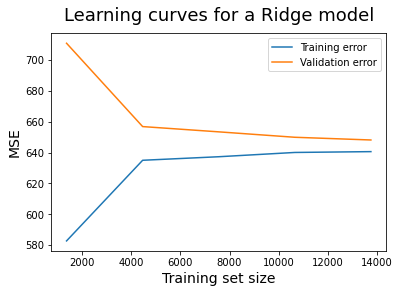

In [24]:
# plot the learning curve for the tuned Ridge regression model
plt.subplot()
learning_curves(opt_ridge_reg, X, y)

Interpretation:  The training and validation error are converging suggesting that adding more training instances may improve the model a little bit, but is unlikely to make a huge difference.  The validation error is high indicating a bias problem and the observation that the training error is also high indicates that the model's issue is a high bias problem meaning the model doesn't describe the relationship between feature and target especially well. The small gap between the training and validation error points to low variance.  Overall this model high bias, low varience and is underfitting the training data. 

Standard fixes:  
1.  Increasing feature number:  I tried that by adding polynomial featuers and the RMSE of the ridge regression model improved and then decreased as the power increased. See plot below. 
2.  Decreasing regularization:  The best alpha for this model was found to be 0.13 which is already a low level of regularization. 

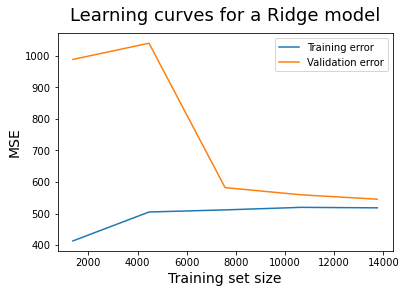

In [35]:
# plot learning curve for the tuned ridge regression model using polynomial (power=4) feature set
plt.subplot()
learning_curves(opt_ridge_reg_poly, poly_features["poly_X_4"], y)

Interpretation:  Adding the polynomial features helped the ridge regression model quite a bit as the validation and training errors were lower than with the original dataset. The model is converging, but not as quickly as the ridge model using the original dataset so more instances maybe helpful. 

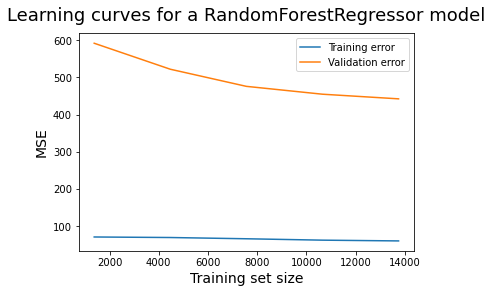

In [43]:
# plot the learning curve for the tuned RandomForestRegressor model
plt.subplot()
learning_curves(opt3_RF_reg, X, y)

### Results:
The validation error is lower than that seen in the ridge_reg model above so this model has less bias.  The large gap between the training and validation error curves indicated a high level of variance.  In fact the validation curve does not increase at all.  This low bias, high variance model is overfitting the training data and would likely be improved by adding additional instances to the training dataset.  

Standard fixes:   
1.  Increasing the number of instances:  This possible as there are additional years of data available.
2.  Increase the regularization to prevent overfitting:  Could plot various parameter tuning results to see if that helped. 
3.  Reduce the number of features which will lead to less complex models:  I tried that by using a smaller feature set (see next section) and the overfitting did not improve at all. 

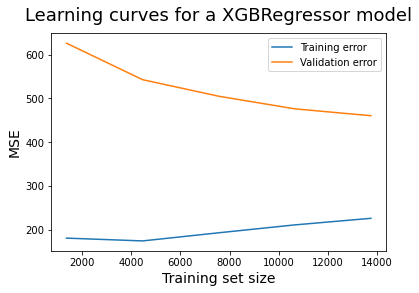

In [27]:
plt.subplot()
learning_curves(opt_XGB_reg, X, y)

### Results:
The validation error is lower than that seen in the ridge_reg model above and approximately equivalent to the RF_reg model.  There is still a large gap between the training and validation error curves, but unlike with the RF_reg model is the validation error is starting to converge towards the training error.  Like the RF_reg, this is a low bias, high variance model that is overfitting the training data and would likely be improved by adding additional instances to the dataset.  It may need less instances than the RF_reg model as it is already starting to converge. 

Standard fixes:   
1.  Increasing the number of instances:  This possible as there are additional years of data available
2.  Increase the regularization to prevent overfitting:  Could plot various parameter tuning results to see if that helps. 
3.  Reduce the number of features which will lead to less complex models:  I tried that below by using the small feature set and the training error no longer started to converge so that was not a succesful fix. 

## Revisiting the smaller feature set for the Random forest and XGBoost models

Try tuning the hyperparameters on models built using the smaller feature set.  Less features increases the regularization for Random Forest models.  Does it do the same for XGBoost?  Are the learning curves improved?

In [48]:
# XGBoost 
# split the training set into train and validate
X_train, X_validate, y_train, y_validate = train_test_split(X_small, y, test_size=0.3, random_state=46)

# run the hyperparameter tuning trials
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

100%|██████████| 100/100 [01:17<00:00,  1.30trial/s, best loss: 517.6630424645158]
{'colsample_bytree': 0.6007687980933383, 'gamma': 6.083610095367174, 'max_depth': 11.0, 'min_child_weight': 1.0, 'reg_alpha': 173.0, 'reg_lambda': 0.7505347192447069}


In [49]:
opt_XGB_small_reg = XGBRegressor(colsample_bytree=0.60, gamma=6.08, max_depth=11, min_child_weight=1, reg_alpha=173, reg_lambda=0.75)
opt_XGB_small_df = model_testing(X_small, y, [opt_XGB_small_reg], ["opt_XGB_small_reg"])

running opt_XGB_small_reg


In [50]:
opt_XGB_small_df

opt_XGB_small_reg
0          21.701323
1           0.897328

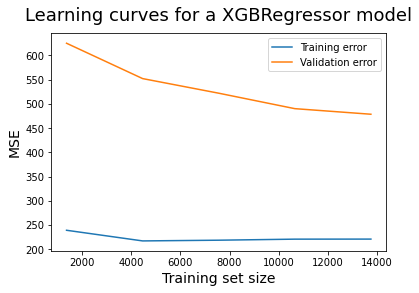

In [60]:
plt.subplot()
learning_curves(opt_XGB_small_reg, X_small, y)

### Results
The RMSE using the default settings on the small subet was 21.81 while after hyperparameter optimization, the RMSE dropped to 21.70.  This was an improvement of 0.11 while tuning with the full subset improved the RMSE 0.25 (from 21.7 to 21.45).  The learning curve for the model trained on the smaller feature set actually looks worse as the training error stays flat indicating this tuned, small subset model is likely overfitting the data more than the tuned, full dataset model. 

In [51]:
# RandomForest
# parameter suggestions from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# took 1.5 hrs to run

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=RF_reg, param_distributions=random_grid, scoring='neg_mean_squared_error',
                               n_iter=100, cv=3, verbose=2, random_state=46, n_jobs = -1)

rf_random.fit(X_small, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=46, scoring='neg_mean_squared_error',
                   verbose=2)

In [53]:
rf_random.best_score_

-465.0750940742799

In [55]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [56]:
opt_RF_small_reg = RandomForestRegressor(n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features='sqrt',
 max_depth=80, bootstrap=False)
opt3_RF_reg_results_df = model_testing(X_small, y, [opt_RF_small_reg], ["opt_RF_small_reg"])

running opt_RF_small_reg


In [57]:
opt3_RF_reg_results_df

opt_RF_small_reg
0         21.016610
1          1.136571

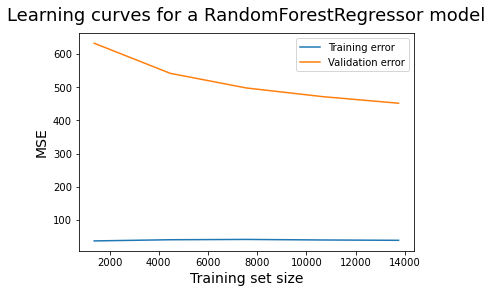

In [59]:
plt.subplot()
learning_curves(opt_RF_small_reg, X_small, y)

### Results:

The RMSE using the default settings on the small subet was 21.37 while after hyperparameter optimization, the RMSE dropped to 21.02.  This was an improvement of 0.35 while tuning with the full subset improved the RMSE 0.15 from 20.96 to 20.81. However, the learning curve did not improve at all and the training error remains flat. 

## r2 error

Calculate the r2 error for the best of the three types of regression models. 

In [39]:
def R2_model_testing(X, y, models, model_names):
    """Takes a pandas df of prepared features, a pandas series of corresponding targets and runs all models 
    specificed in the "models" list in a cross validation scheme with 10 folds. Returns a dataframe containing
    the mean R2 and mean std for each model.
    
    Arguments:
    X -- pandas dataframe containing feature values
    y -- pandas series containing the target values
    models -- list of scikit models
    model_names -- list of strings of model names
    
    Returns:
    pandas dataframe containing the mean RMSE and mean standard deviation for each model in the "models" list
    """
    model_results = {}
    for count, model in enumerate(models):
        print("running", model_names[count])
        scores = cross_val_score(model, X, y, scoring="r2", cv=10)
        model_results[model_names[count]] = [scores.mean(), scores.std()]
    df = pd.DataFrame(model_results) 
    return df

In [40]:
R2_opt_ridge_reg_poly_df = R2_model_testing(poly_features["poly_X_4"], y, [opt_ridge_reg_poly], ["opt_ridge_reg_poly"])

running opt_ridge_reg_poly]


In [41]:
R2_opt_ridge_reg_poly_df

opt_ridge_reg_poly]
0             0.733174
1             0.021892

In [44]:
R2_opt3_RF_reg_df = R2_model_testing(X, y, [opt3_RF_reg], ['opt3_RF_reg'])

running opt3_RF_reg


In [45]:
R2_opt3_RF_reg_df

opt3_RF_reg
0     0.786502
1     0.015065

In [48]:
R2_opt_XGB_reg_df = R2_model_testing(X, y, [opt_XGB_reg], ['opt_XGB_reg'])

running opt_XGB_reg


In [49]:
R2_opt_XGB_reg_df

opt_XGB_reg
0     0.773971
1     0.010272

## Final results  

The model that has the best RMSE and R2 scores is the Random Forest model using the full feature set.